In [43]:
from __future__ import absolute_import, division, print_function

# Import Tensorflow, Tensorflow Dataset and Layers Functions for Convolutional Neural Network
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=8, 
    min_delta=0.001, 
    mode='max'
)

# VGG16
# from tensorflow.keras.applications.vgg16 import VGG16

# Inception
# from tensorflow.keras.applications.inception_v3 import InceptionV3

# ResNet 50
# from tensorflow.keras.applications import ResNet50

# MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.models import Model
# tf.logging.set_verbosity(tf.logging.ERROR)

# Import Utils
import math
import numpy as np
import os
import datetime

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

# Upload dataset to Google Drive in a zipped folder and connect this Colab to my Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
# remove a folder
# !rm -rf dataset
# unzip dataset folder
!unzip '/content/gdrive/MyDrive/AI-Assets/dataset.zip' > /dev/null

In [46]:
# dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

# Use my own dataset
dataset_dir = 'dataset/'

# Configuration (Image Size is based on the base model from VGG16)
image_size = 224
batch_size = 32

# Dataset Variables
num_classes = 0
dataset = []
labels = []

In [47]:
# Get the number of examples for the training and examples for the testing
# num_train_examples = metadata.splits['train'].num_examples
# num_test_examples = metadata.splits['test'].num_examples
# print(num_train_examples, num_test_examples)

train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

# Train
# Directory with the Drowsy pictures
train_drowsy_dir = os.path.join(train_dir, 'Drowsy')
# Directory with the Non-Drowsy pictures
train_non_drowsy_dir = os.path.join(train_dir, 'Non-Drowsy')

# Test
# Directory with the Drowsy pictures
test_drowsy_dir = os.path.join(test_dir, 'Drowsy')
# Directory with the Non-Drowsy pictures
test_non_drowsy_dir = os.path.join(test_dir, 'Non-Drowsy')

# Validation
# Directory with the Drowsy pictures
val_drowsy_dir = os.path.join(val_dir, 'Drowsy')
# Directory with the Non-Drowsy pictures
val_non_drowsy_dir = os.path.join(val_dir, 'Non-Drowsy')

In [48]:
train_drowsy_fnames = os.listdir(train_drowsy_dir)
train_non_drowsy_fnames = os.listdir(train_non_drowsy_dir)

test_drowsy_fnames = os.listdir(test_drowsy_dir)
test_non_drowsy_fnames = os.listdir(test_non_drowsy_dir)

val_drowsy_fnames = os.listdir(val_drowsy_dir)
val_non_drowsy_fnames = os.listdir(val_non_drowsy_dir)

print('total training drowsy images:', len(train_drowsy_fnames))
print('total training non-drowsy images:', len(train_non_drowsy_fnames))

print('total testing drowsy images:', len(test_drowsy_fnames))
print('total testing non-drowsy images:', len(test_non_drowsy_fnames))

print('total validation drowsy images:', len(val_drowsy_fnames))
print('total validation non-drowsy images:', len(val_non_drowsy_fnames))

print('A training drowsy images:', train_drowsy_fnames[0])
print('A training non-drowsy images:', train_non_drowsy_fnames[0])

print('A testing drowsy images:', test_drowsy_fnames[0])
print('A testing non-drowsy images:', test_non_drowsy_fnames[0])

print('A validation drowsy images:', val_drowsy_fnames[0])
print('A validation non-drowsy images:', val_non_drowsy_fnames[0])

total training drowsy images: 102
total training non-drowsy images: 102
total testing drowsy images: 13
total testing non-drowsy images: 13
total validation drowsy images: 13
total validation non-drowsy images: 13
A training drowsy images: man-very-tired-office-work-260nw-285725876.png
A training non-drowsy images: face-young-child-stunning-hazel-260nw-1402748219.png
A testing drowsy images: girl-tired-260nw-476276533.png
A testing non-drowsy images: young-african-woman-looking-seriously-260nw-55855033.png
A validation drowsy images: 494617_1_En_8_Fig5_HTML_5.png
A validation non-drowsy images: serious-man-portrait-real-people-260nw-123213460.png


In [49]:
# def normalize(images, labels):
#   # Cast every pixel value to the float type
#   images = tf.cast(images, tf.float32)
#   # Normalize the pixel values from 0-255 to 0-1
#   images /= 255
#   return images, labels

# train_dataset = train_drowsy_fnames.map(normalize)
# test_dataset = train_non_drowsy_fnames.map(normalize)

# # Take a single image, remove the color dimension by reshaping
# for image, label in test_dataset.take(1):
#   break
# image = image.numpy().reshape((28, 28))

# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size)

# validation dataset (used during training)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size)

# # testing dataset (images not seen by the network)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size)

Found 204 files belonging to 2 classes.
Found 26 files belonging to 2 classes.
Found 26 files belonging to 2 classes.


In [50]:
# load class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Drowsy', 'Non-Drowsy']


In [51]:
# Plot the image
# plt.figure()
# plt.imshow(image, cmap=plt.cm.binary)
# plt.colorbar()
# plt.grid(False)
# plt.show()

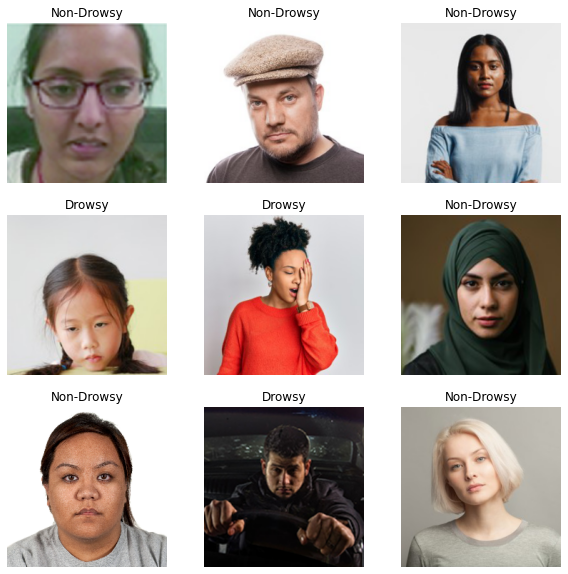

In [52]:
# Display 25 images
# plt.figure(figsize=(10, 10))
# i = 0
# for (image, label) in test_dataset.take(25):
#   image = image.numpy().reshape((28, 28))
#   plt.subplot(5, 5, i + 1)
#   plt.xticks([])
#   plt.yticks([])
#   plt.grid(False)
#   plt.imshow(image, cmap=plt.cm.binary)
#   plt.xlabel(class_names[label])
#   i += 1
# plt.show()

# show example images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

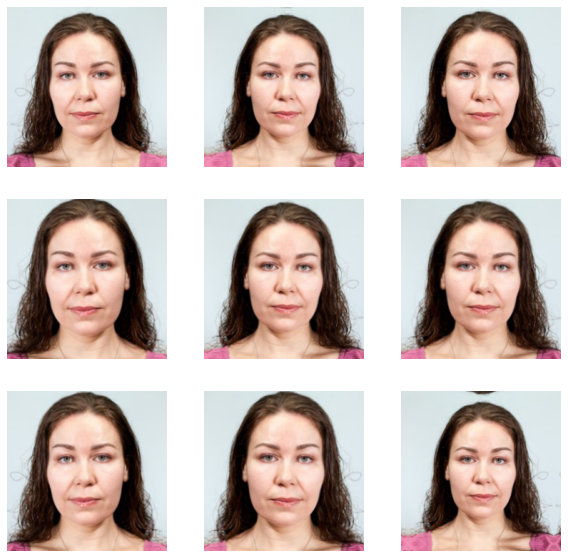

In [53]:
# define data augmentation layer
# https://www.tensorflow.org/tutorials/images/classification#data_augmentation
data_augmentation = Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                                                     input_shape=(image_size,
                                                                  image_size,
                                                                  3)),
        # layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

# show example of augmented data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

In [54]:
# define resizing layer
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1. / 255)
])

In [55]:
base_model = MobileNetV2(input_shape = (image_size, image_size, 3), # Shape of the images
                  include_top = False, # Leave out the last fully connected layer
                  weights = 'imagenet')

# Freeze other layers
for layer in base_model.layers:
    layer.trainable = False

In [56]:
 base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_32[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [66]:
# Extract needed layers for transfer learning
base_model_input = base_model.input
base_model_output = base_model.layers[-3].output
print(base_model.layers[-3].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None), name='Conv_1/Conv2D:0', description="created by layer 'Conv_1'")


In [67]:
# Create Convolutional Model
# Need Same The Number of Inputted Image Sizes and Outputs for Transfer Learning 
# model = Sequential([
#   data_augmentation,
#   resize_and_rescale,
#   Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(image_size, image_size, 3)),
#   MaxPooling2D((2, 2), strides=2),
#   Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
#   MaxPooling2D((2, 2), strides=2),
#   Conv2D(128, (3, 3), padding='same', activation=tf.nn.relu),
#   MaxPooling2D((2, 2), strides=2),
#   Conv2D(256, (3, 3), padding='same', activation=tf.nn.relu),
#   MaxPooling2D((2, 2), strides=2),
#   Flatten(),
#   Dropout(0.2),
#   Dense(4096, activation=tf.nn.relu),
#   Dense(num_classes, activation=tf.nn.softmax)
# ])

# Rebuild the last fully-connected layer
# Flatten the output layer to 1 dimension
# x = layers.Flatten()(base_model_output)

# # Add a fully connected layer with 1024 hidden units and ReLU activation
# x = layers.Dense(1024, activation=tf.nn.relu)(x)

# # Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)

# # Add a final sigmoid layer for classification
# x = layers.Dense(num_classes, activation=tf.nn.softmax)(x)

# model = Model(
#     base_model_input,
#     x
# )

# DIFFERENCES: NO MORE FULLY CONNECTED LAYER WITH THE RELU FUNCTION
# Define a sequential model
model = base_model_output

# Add the pretrained model
model = GlobalAveragePooling2D()(model)


# Change the fully connected layer with the right number of classes
model = Dense(num_classes, activation=tf.nn.softmax)(model)

# Define a new model
classifier_model = Model(base_model_input, model)


classifier_model.summary()
# model_last_convlayer_name = model.layers[-6].name
# print(model_last_convlayer_name)

Model: "model_62"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_32[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

In [68]:
classifier_model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
# FITTING CALLBACK

# This is to collect training stats of each batch
# class CollectBatchStats(keras.callbacks.Callback):
#   def __init__(self):
#     self.batch_losses = []
#     self.batch_acc = []

#   def on_train_batch_end(self, batch, logs = None):
#     self.batch_losses.append(logs['loss'])
#     self.batch_acc.append(logs['acc'])
#     self.model.reset_metrics()

# # Create a callback function to stop training when a condition is satisfied
# class earlyStopCallback(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs = {}):
#     # Set an accuracy threshold
#     accuracy_threshold = 0.9
#     # Check if the threshold is reached
#     if logs.get('val_acc') > accuracy_threshold and logs.get('acc') > accuracy_threshold:
#       global last_epoch
#       last_epoch = epoch
#       self.model.stop_training = True

In [70]:
# Instantiation of Callbacks Features
# tensorboard preparation
my_model_name = "vu_drowsiness_model"
log_dir = "logs/fit/" + my_model_name + "-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# batch_stats_callback = CollectBatchStats()

# # list of callbacks
callback_list = [early_stopping, tensorboard_callback]

In [71]:
# Number of Epochs for Transfer Learning
epochs = 6

In [72]:
# Fit the model
history = classifier_model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2, callbacks=callback_list)

Epoch 1/6
7/7 - 8s - loss: 0.7004 - accuracy: 0.5245 - val_loss: 0.7338 - val_accuracy: 0.4615
Epoch 2/6
7/7 - 4s - loss: 0.6324 - accuracy: 0.6667 - val_loss: 0.6861 - val_accuracy: 0.4231
Epoch 3/6
7/7 - 5s - loss: 0.6045 - accuracy: 0.6863 - val_loss: 0.6834 - val_accuracy: 0.5769
Epoch 4/6
7/7 - 4s - loss: 0.5768 - accuracy: 0.7304 - val_loss: 0.7053 - val_accuracy: 0.5769
Epoch 5/6
7/7 - 5s - loss: 0.5585 - accuracy: 0.7647 - val_loss: 0.6707 - val_accuracy: 0.5385
Epoch 6/6
7/7 - 5s - loss: 0.5491 - accuracy: 0.7500 - val_loss: 0.6945 - val_accuracy: 0.5769


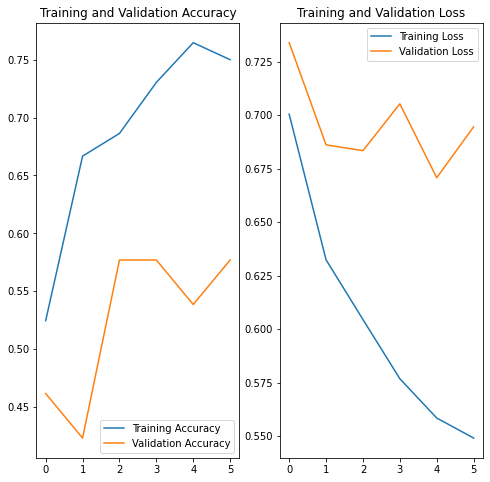

In [74]:
# plot the training metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [75]:
test_loss, test_accuracy = classifier_model.evaluate(test_ds)
print('Accuracy on test dataset:', test_accuracy)

1/1 [==============================] - 0s 125ms/step - loss: 0.6043 - accuracy: 0.7308
Accuracy on test dataset: 0.7307692170143127


In [76]:
# Make prediction
for test_images, test_labels in test_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = classifier_model.predict(test_images)

In [77]:
predictions.shape

(26, 2)

In [78]:
predictions[0]

array([0.7584357 , 0.24156427], dtype=float32)

In [79]:
prediction_id = np.argmax(predictions, axis=-1)
print(prediction_id)

[0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0]


In [80]:
test_images[0]

array([[[242.     , 247.     , 243.     ],
        [242.     , 247.     , 243.     ],
        [242.     , 247.     , 243.     ],
        ...,
        [241.     , 246.     , 242.     ],
        [240.26785, 245.26785, 241.26785],
        [240.     , 245.     , 241.     ]],

       [[242.     , 247.     , 243.     ],
        [242.     , 247.     , 243.     ],
        [242.     , 247.     , 243.     ],
        ...,
        [241.     , 246.     , 242.     ],
        [240.26785, 245.26785, 241.26785],
        [240.     , 245.     , 241.     ]],

       [[242.     , 247.     , 243.     ],
        [242.     , 247.     , 243.     ],
        [242.     , 247.     , 243.     ],
        ...,
        [241.     , 246.     , 242.     ],
        [240.26785, 245.26785, 241.26785],
        [240.     , 245.     , 241.     ]],

       ...,

       [[226.     , 231.80359, 226.5982 ],
        [226.10762, 231.91121, 226.70583],
        [226.4018 , 232.20538, 227.     ],
        ...,
        [197.94057, 203.94

In [81]:
 test_labels[0]

0

In [82]:
np.argmax(predictions[0])

0

In [83]:
np.max(predictions[0])

0.7584357

In [84]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  print(predictions_array)
  # Setup the chart
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  # plt.imshow(img[...,0], cmap=plt.cm.gray)
  # Show images in RGB colour
  plt.imshow(img.astype('uint8'))

  # Get the largest value
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  # Plot information on the x axis
  # Class name with the index the largest value from the predicted label
  # Find the maximum 
  plt.xlabel("{} {:2.0f}% ( {} )".format(class_names[predicted_label],
                                          100 * np.max(predictions_array),
                                          class_names[true_label]),
                                          color=color)
  
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

[0.7584357  0.24156427]


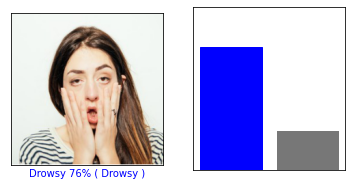

In [85]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

[0.78047866 0.21952134]


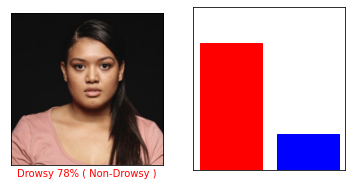

In [86]:
i = 12
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

[0.7584357  0.24156427]
[0.76497126 0.23502879]
[0.98622173 0.01377822]
[0.3103895  0.68961054]
[0.20413718 0.79586285]
[0.7110391 0.2889609]
[0.26657334 0.7334267 ]
[0.04695269 0.9530473 ]
[0.4570033 0.5429967]
[0.9130361  0.08696391]
[0.35202235 0.6479776 ]
[0.91077703 0.089223  ]
[0.78047866 0.21952134]
[0.44533685 0.5546632 ]
[0.23030683 0.7696932 ]


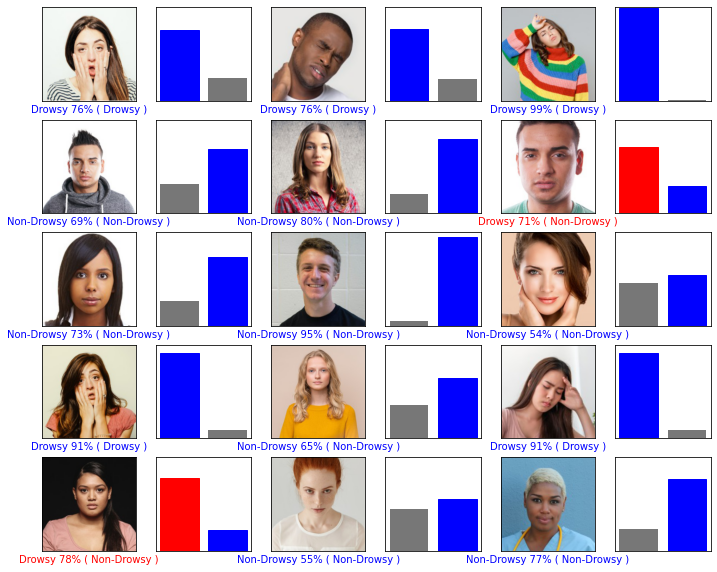

In [87]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blbue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
figsize = (2 * 2 * num_cols, 2 * num_rows)
plt.figure(figsize=figsize)
for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
  plot_value_array(i, predictions, test_labels)

In [88]:
# Save model for future testing
model_dir = "models/saved/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
classifier_model.save(model_dir)

INFO:tensorflow:Assets written to: models/saved/20210322-133412/assets


In [89]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Second, create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    # Then, compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [90]:
def superimposedImg(heatmap, image):
  # Reverse the normalisation process
  heatmap = np.uint8(255 * heatmap)

  jet = cm.get_cmap("jet")

  # Use RGB values
  jet_colours = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colours[heatmap]

  # Create an image with RGB colourised heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  # Resize the heat map's resolution to the image's
  jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Super-impose the heatmap on original image
  opacity = 0.4
  superimposed = jet_heatmap * opacity + image
  superimposed = keras.preprocessing.image.array_to_img(superimposed)
  return superimposed

In [91]:
def plot_heat_map(last_conv_layer_name, classifier_layer_names, superimposed):
  for n in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * n + 1)
    array = keras.preprocessing.image.img_to_array(test_images[n])
    # Add a dimension to transform the image array into a "batch"
    # of size (1, 244, 244, 3)
    array = np.expand_dims(array, axis=0)

    heatmap = make_gradcam_heatmap(array, classifier_model, last_conv_layer_name, classifier_layer_names)

    if superimposed:
      plt.imshow(superimposedImg(heatmap, test_images[n]))
    else:
      plt.imshow(heatmap)
    # print(test_labels[n])

    # Get the largest value
    predicted_label = np.argmax(predictions[n])
    print(predicted_label, test_labels[n])

    if predicted_label == test_labels[n]:
      plt.title("{} {:2.0f}% ( {} )".format(class_names[predicted_label],
                                            100 * np.max(predictions[n]),
                                            class_names[test_labels[n]]),
                                            color="blue")
    else:
      plt.title("{} {:2.0f}% ( {} )".format(class_names[predicted_label],
                                            100 * np.max(predictions[n]),
                                            class_names[test_labels[n]]),
                                            color="red")

    plt.axis('off')

  plt.show()

0 0
0 0
0 0
1 1
1 1
0 1
1 1
1 1
1 1
0 0
1 1
0 0
0 1
1 1
1 1


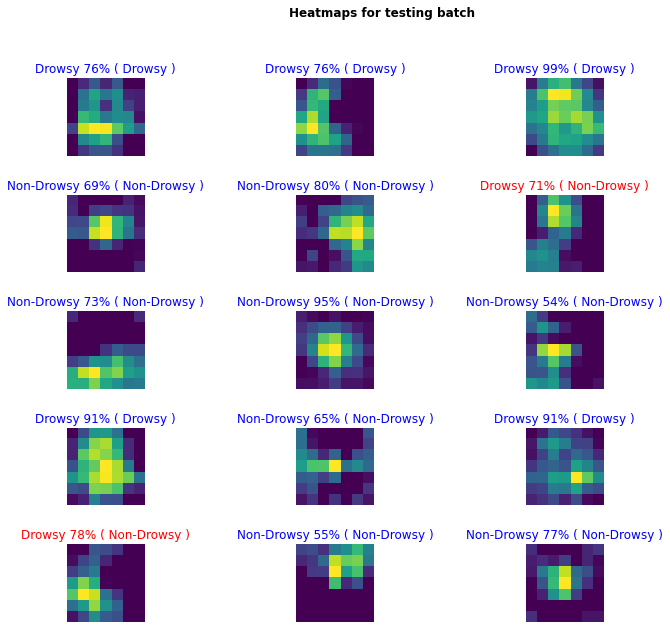

In [92]:
# HEAT MAP

# Get the name of the last conv layer
last_conv_layer_name = classifier_model.layers[-3].name
# Get the name of the last dense layers
classifier_layer_names = [
    classifier_model.layers[-2].name,
    classifier_model.layers[-1].name,
]

# Show heat maps
plt.figure(figsize=figsize)
plt.suptitle("Heatmaps for testing batch", fontweight='bold')
plt.subplots_adjust(hspace=0.5)
plot_heat_map(last_conv_layer_name, classifier_layer_names, False)

0 0
0 0
0 0
1 1
1 1
0 1
1 1
1 1
1 1
0 0
1 1
0 0
0 1
1 1
1 1


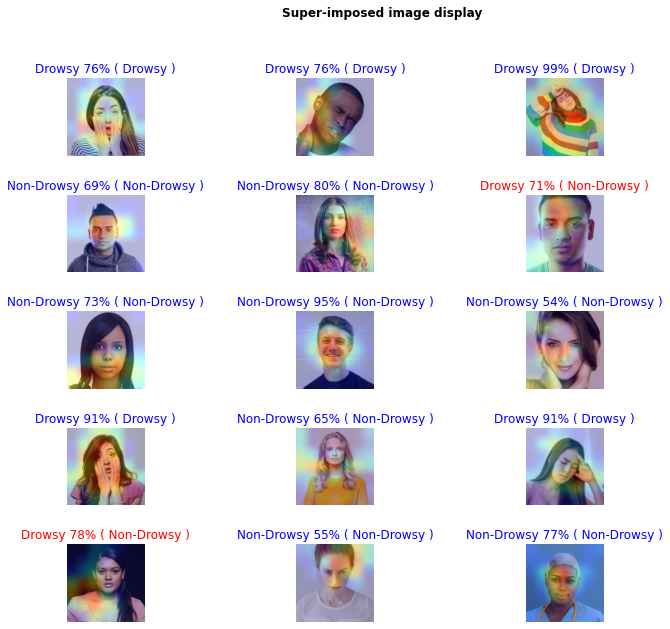

In [93]:
# Show super-imposed image
plt.figure(figsize=figsize)
plt.suptitle("Super-imposed image display", fontweight='bold')
plt.subplots_adjust(hspace=0.5)
plot_heat_map(last_conv_layer_name, classifier_layer_names, True)